# Data Preprocessing

In [1]:
import sys, os

# Add the parent directory containing IBM_GNN to sys.path
project_root = "/Users/hanbeobmun/Desktop/대학원/연구실/Fraud_detection_GNN"
if project_root not in sys.path:
    sys.path.append(project_root)

from IBM_GNN.IBM_dataset import IBM_Dataset
import numpy as np

TRANSACTIONS_CSV_PATH = '../data/IBM_Credit_Card_Transaction/credit_card_transactions-ibm_v2.csv'
USERS_CSV_PATH = '../data/IBM_Credit_Card_Transaction/sd254_users.csv'
CARDS_CSV_PATH = '../data/IBM_Credit_Card_Transaction/sd254_cards.csv'

try:
    dataset = (IBM_Dataset()
                .read_transactions_csv(TRANSACTIONS_CSV_PATH)
                .read_users_csv(USERS_CSV_PATH)
                .read_cards_csv(CARDS_CSV_PATH)
                .preprocess_transactions()
                .preprocess_users()
                .preprocess_cards()
                .create_node_mappings()
                )
except Exception as e:
    print(f"Error occurred: {e}")

Loading transactions CSV...
Transactions CSV loaded successfully.
Users CSV loaded successfully.
Cards CSV loaded successfully.


Preprocessing transactions completed.
Preprocessing users completed.
Preprocessing cards completed.
Total unique nodes: 106482


In [2]:
dataset.edge_transactions

,Date,isFraud,Src,Dest,Relation,Scaled_Amount,MCC_idx,Zip_idx,Use Chip_Chip Transaction,Use Chip_Online Transaction,Use Chip_Swipe Transaction,Error_Bad Expiration,Error_Technical Glitch,Error_Bad PIN,Error_Bad CVV,Error_Insufficient Balance,Error_Bad Zipcode,Error_Bad Card Number
0,1991-01-02,0,791_1,2027553650310142703,transaction,0.449253,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1991-01-02,0,2027553650310142703,791_1,refund,0.449253,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1991-01-02,0,791_1,2027553650310142703,transaction,0.503102,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991-01-02,0,791_1,-7269691894846892021,transaction,0.504125,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1991-01-03,0,791_1,-3693650930986299431,transaction,0.586990,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,2020-02-28,0,1659_2,7231700044622779845,transaction,0.229169,14,7040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24386896,2020-02-28,0,863_1,7654254764356253071,transaction,0.415206,10,12443,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24386897,2020-02-28,0,1366_2,-7398558035733466800,transaction,0.519464,5,12809,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24386898,2020-02-28,0,1300_0,-6458444334611773637,transaction,0.419831,97,29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc, f1_score

edge_transactions = dataset.edge_transactions
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
relation_onehot = onehot_encoder.fit_transform(edge_transactions[['Relation']])
relation_types = onehot_encoder.get_feature_names_out(['Relation'])
relation_df = pd.DataFrame(relation_onehot, columns=relation_types, index=edge_transactions.index)
edge_transactions = pd.concat([relation_df, edge_transactions], axis=1)
edge_transactions = edge_transactions.drop(columns=['Relation'])
edge_transactions.head()

,Relation_refund,Relation_transaction,Date,isFraud,Src,Dest,Scaled_Amount,MCC_idx,Zip_idx,Use Chip_Chip Transaction,Use Chip_Online Transaction,Use Chip_Swipe Transaction,Error_Bad Card Number,Error_Bad Zipcode,Error_Technical Glitch,Error_Bad PIN,Error_Insufficient Balance,Error_Bad Expiration,Error_Bad CVV
0,0.0,1.0,1991-01-02,0,791_1,2027553650310142703,0.449253,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1991-01-02,0,2027553650310142703,791_1,0.449253,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1991-01-02,0,791_1,2027553650310142703,0.503102,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1991-01-02,0,791_1,-7269691894846892021,0.504125,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1991-01-03,0,791_1,-3693650930986299431,0.586990,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def get_edge_transactions(edge_transactions, start_date=None, end_date=None):
    if edge_transactions is None:
        raise ValueError("Edge transactions dataframe is not loaded. Please call read_transactions_csv() and preprocess_transactions() first.")
    if start_date is not None and end_date is not None:
        if pd.to_datetime(start_date) == pd.to_datetime(end_date):
            mask = (edge_transactions['Date'] == pd.to_datetime(start_date))
            return edge_transactions.loc[mask].reset_index(drop=True)
        else:
            mask = (edge_transactions['Date'] >= pd.to_datetime(start_date)) & (edge_transactions['Date'] < pd.to_datetime(end_date))
            return edge_transactions.loc[mask].reset_index(drop=True)
    elif start_date is not None and end_date is None:
        mask = (edge_transactions['Date'] >= pd.to_datetime(start_date))
        return edge_transactions.loc[mask].reset_index(drop=True)
    elif start_date is None and end_date is not None:
        mask = (edge_transactions['Date'] < pd.to_datetime(end_date))
        return edge_transactions.loc[mask].reset_index(drop=True)
    else:
        return edge_transactions

In [4]:
start_date = '1996-01-01'
end_date = '2020-01-01'

days = pd.date_range(start=start_date, end=end_date, freq='D')
train_data, test_data = [], []
s = 0.4
for i in range(5):
    t_e = int(len(days) * s)
    train_end_date = days[t_e]
    test_start_date = days[t_e]
    test_end_date = days[min(int(len(days)*(s+0.2)), len(days)-1)]
    print(train_end_date, test_start_date, test_end_date)
    train_d = get_edge_transactions(edge_transactions, end_date=train_end_date)
    test_d = get_edge_transactions(edge_transactions, start_date=test_start_date, end_date=test_end_date)
    train_data.append(train_d)
    test_data.append(test_d)
    s += 0.1

2005-08-07 00:00:00 2005-08-07 00:00:00 2010-05-27 00:00:00
2008-01-01 00:00:00 2008-01-01 00:00:00 2012-10-19 00:00:00
2010-05-27 00:00:00 2010-05-27 00:00:00 2015-03-15 00:00:00
2012-10-19 00:00:00 2012-10-19 00:00:00 2017-08-08 00:00:00
2015-03-15 00:00:00 2015-03-15 00:00:00 2020-01-01 00:00:00


In [23]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, transactions):
        self.mcc_idx = torch.tensor(transactions[['MCC_idx']].values, dtype=torch.long)
        self.zip_idx = torch.tensor(transactions[['Zip_idx']].values, dtype=torch.long)
        self.transaction = torch.tensor(transactions.drop(columns=['Src', 'Dest', 'MCC_idx', 'Zip_idx', 'Date', 'isFraud']).values, dtype=torch.float)
        self.label = torch.tensor(transactions['isFraud'].values, dtype=torch.float).unsqueeze(1)
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.transaction[idx], self.mcc_idx[idx], self.zip_idx[idx], self.label[idx]


# DNN

## Model Architecture

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self, transactions_dim, zip_emb_dim, mcc_emb_dim, num_zip_idx, num_mcc_idx):
        super(DNN, self).__init__()
        self.zip_embedding = nn.Embedding(num_zip_idx, zip_emb_dim)
        self.mcc_embedding = nn.Embedding(num_mcc_idx, mcc_emb_dim)
        self.fc1 = nn.Linear(transactions_dim + zip_emb_dim + mcc_emb_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, transactions, zip_idx, mcc_idx):
        zip_emb = self.zip_embedding(zip_idx).squeeze(1)
        mcc_emb = self.mcc_embedding(mcc_idx).squeeze(1)
        x = torch.cat([transactions, zip_emb, mcc_emb], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [25]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        inputs = torch.clamp(inputs, min=1e-7, max=1 - 1e-7)
        pt = inputs * targets + (1 - inputs) * (1 - targets)
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        modulating_factor = (1 - pt) ** self.gamma
        focal_loss = alpha_factor * modulating_factor * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

## Train

In [26]:
import matplotlib.pyplot as plt

def plot_metrics(result):
    # Plot train/val loss, ROC-AUC, PR-AUC side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    epochs = np.arange(1, len(result) + 1)

    # Loss plot
    axes[0].plot(epochs, result['train_loss'], label='train_loss')
    axes[0].plot(epochs, result['val_loss'], label='val_loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='upper left')
    axes[0].grid(alpha=0.3)

    # ROC-AUC plot
    axes[1].plot(epochs, result['train_roc_auc'], label='train_roc_auc')
    axes[1].plot(epochs, result['val_roc_auc'], label='val_roc_auc')
    axes[1].set_title('ROC AUC')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('ROC AUC')
    axes[1].legend(loc='upper left')
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim(0.0, 1.0)

    # PR-AUC plot
    axes[2].plot(epochs, result['train_pr_auc'], label='train_pr_auc')
    axes[2].plot(epochs, result['val_pr_auc'], label='val_pr_auc')
    axes[2].set_title('PR AUC (Average Precision)')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('PR AUC')
    axes[2].legend(loc='upper left')
    axes[2].grid(alpha=0.3)
    axes[2].set_ylim(0.0, 1.0)

    plt.tight_layout()
    plt.show()

In [ ]:
import os

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='DNN/checkpoint.pt', metric_name='metric'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path
        self.metric_name = metric_name

    def __call__(self, val_metric, model):
        score = val_metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_metric, model)
            self.counter = 0
    
    def save_checkpoint(self, val_metric, model):
        if self.verbose:
            print(f'Validation {self.metric_name} improved ({self.best_score:.6f} --> {val_metric:.6f}).  Saving model ...')
        os.makedirs(os.path.dirname('training_results/DNN/'), exist_ok=True)
        torch.save(model.state_dict(), self.path)
        self.best_score = val_metric

In [35]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, f1_score

def get_max_f1_score(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    max_f1 = np.max(f1_scores)
    return max_f1, optimal_threshold

Fold 1 Train Epoch 1/10, Loss: 0.0058, ROC_AUC: 0.6634, PR_AUC: 0.0010, F1_Score: 0.0028 | Test Loss 0.0011, ROC_AUC: 0.8671, PR_AUC: 0.0355, F1_Score: 0.1246


Fold 1 Train Epoch 2/10, Loss: 0.0004, ROC_AUC: 0.9610, PR_AUC: 0.0492, F1_Score: 0.1066 | Test Loss 0.0010, ROC_AUC: 0.8790, PR_AUC: 0.1377, F1_Score: 0.2362


Fold 1 Train Epoch 3/10, Loss: 0.0003, ROC_AUC: 0.9774, PR_AUC: 0.1571, F1_Score: 0.2485 | Test Loss 0.0010, ROC_AUC: 0.8834, PR_AUC: 0.1670, F1_Score: 0.2816


Fold 1 Train Epoch 4/10, Loss: 0.0003, ROC_AUC: 0.9829, PR_AUC: 0.2250, F1_Score: 0.3098 | Test Loss 0.0010, ROC_AUC: 0.8843, PR_AUC: 0.1992, F1_Score: 0.3395


Fold 1 Train Epoch 5/10, Loss: 0.0003, ROC_AUC: 0.9870, PR_AUC: 0.2599, F1_Score: 0.3567 | Test Loss 0.0010, ROC_AUC: 0.8841, PR_AUC: 0.2229, F1_Score: 0.3589


Fold 1 Train Epoch 6/10, Loss: 0.0002, ROC_AUC: 0.9890, PR_AUC: 0.3055, F1_Score: 0.3854 | Test Loss 0.0010, ROC_AUC: 0.8832, PR_AUC: 0.2515, F1_Score: 0.3595


Fold 1 Train Epoch 7/10, Loss: 0.0002, ROC_AUC: 0.9907, PR_AUC: 0.3361, F1_Score: 0.4104 | Test Loss 0.0010, ROC_AUC: 0.8819, PR_AUC: 0.2689, F1_Score: 0.3720


Fold 1 Train Epoch 8/10, Loss: 0.0002, ROC_AUC: 0.9908, PR_AUC: 0.3394, F1_Score: 0.4095 | Test Loss 0.0010, ROC_AUC: 0.8847, PR_AUC: 0.2834, F1_Score: 0.3691


Fold 1 Train Epoch 9/10, Loss: 0.0002, ROC_AUC: 0.9923, PR_AUC: 0.3921, F1_Score: 0.4501 | Test Loss 0.0010, ROC_AUC: 0.8852, PR_AUC: 0.3096, F1_Score: 0.3903


Fold 1 Train Epoch 10/10, Loss: 0.0002, ROC_AUC: 0.9939, PR_AUC: 0.4126, F1_Score: 0.4631 | Test Loss 0.0010, ROC_AUC: 0.8856, PR_AUC: 0.3254, F1_Score: 0.3955


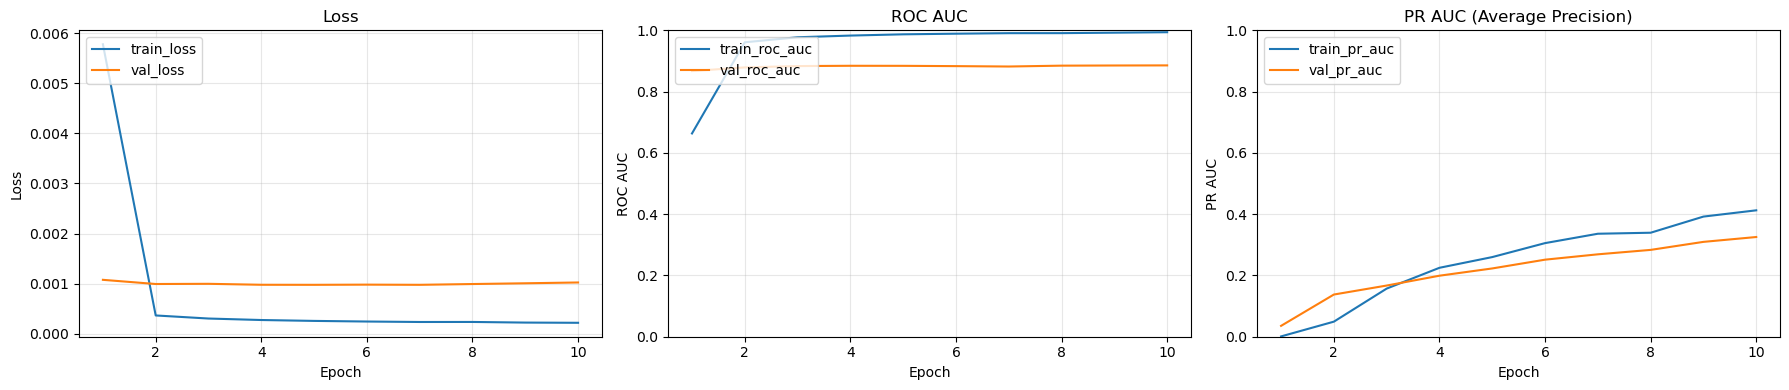

Fold 2 Train Epoch 1/10, Loss: 0.0045, ROC_AUC: 0.7540, PR_AUC: 0.0025, F1_Score: 0.0076 | Test Loss 0.0007, ROC_AUC: 0.9312, PR_AUC: 0.1213, F1_Score: 0.2299


Fold 2 Train Epoch 2/10, Loss: 0.0005, ROC_AUC: 0.9140, PR_AUC: 0.1359, F1_Score: 0.2396 | Test Loss 0.0006, ROC_AUC: 0.9400, PR_AUC: 0.2288, F1_Score: 0.3431


Fold 2 Train Epoch 3/10, Loss: 0.0005, ROC_AUC: 0.9299, PR_AUC: 0.2137, F1_Score: 0.3170 | Test Loss 0.0006, ROC_AUC: 0.9434, PR_AUC: 0.3044, F1_Score: 0.4538


Fold 2 Train Epoch 4/10, Loss: 0.0004, ROC_AUC: 0.9435, PR_AUC: 0.2830, F1_Score: 0.3789 | Test Loss 0.0006, ROC_AUC: 0.9455, PR_AUC: 0.3688, F1_Score: 0.4817


Fold 2 Train Epoch 5/10, Loss: 0.0004, ROC_AUC: 0.9522, PR_AUC: 0.3315, F1_Score: 0.4147 | Test Loss 0.0006, ROC_AUC: 0.9468, PR_AUC: 0.4107, F1_Score: 0.4968


Fold 2 Train Epoch 6/10, Loss: 0.0004, ROC_AUC: 0.9604, PR_AUC: 0.3695, F1_Score: 0.4328 | Test Loss 0.0006, ROC_AUC: 0.9488, PR_AUC: 0.4359, F1_Score: 0.4985


Fold 2 Train Epoch 7/10, Loss: 0.0004, ROC_AUC: 0.9650, PR_AUC: 0.3972, F1_Score: 0.4428 | Test Loss 0.0006, ROC_AUC: 0.9494, PR_AUC: 0.4527, F1_Score: 0.5027


Fold 2 Train Epoch 8/10, Loss: 0.0004, ROC_AUC: 0.9717, PR_AUC: 0.4181, F1_Score: 0.4499 | Test Loss 0.0006, ROC_AUC: 0.9498, PR_AUC: 0.4652, F1_Score: 0.5133


Fold 2 Train Epoch 9/10, Loss: 0.0004, ROC_AUC: 0.9764, PR_AUC: 0.4377, F1_Score: 0.4631 | Test Loss 0.0006, ROC_AUC: 0.9511, PR_AUC: 0.4703, F1_Score: 0.5269


Fold 2 Train Epoch 10/10, Loss: 0.0004, ROC_AUC: 0.9806, PR_AUC: 0.4519, F1_Score: 0.4731 | Test Loss 0.0006, ROC_AUC: 0.9523, PR_AUC: 0.4825, F1_Score: 0.5361


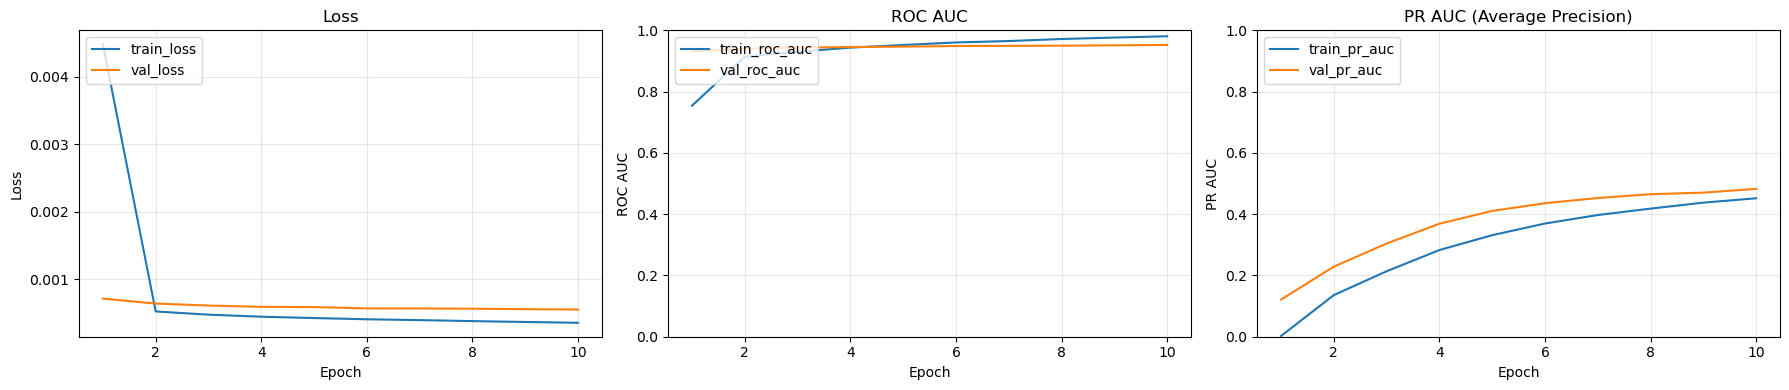

Fold 3 Train Epoch 1/10, Loss: 0.0025, ROC_AUC: 0.8420, PR_AUC: 0.0083, F1_Score: 0.0263 | Test Loss 0.0004, ROC_AUC: 0.9664, PR_AUC: 0.3519, F1_Score: 0.4234


Fold 3 Train Epoch 2/10, Loss: 0.0006, ROC_AUC: 0.9325, PR_AUC: 0.3737, F1_Score: 0.4275 | Test Loss 0.0003, ROC_AUC: 0.9712, PR_AUC: 0.4655, F1_Score: 0.5241


Fold 3 Train Epoch 3/10, Loss: 0.0006, ROC_AUC: 0.9463, PR_AUC: 0.4330, F1_Score: 0.4874 | Test Loss 0.0003, ROC_AUC: 0.9749, PR_AUC: 0.5083, F1_Score: 0.5697


Fold 3 Train Epoch 4/10, Loss: 0.0005, ROC_AUC: 0.9571, PR_AUC: 0.4642, F1_Score: 0.5133 | Test Loss 0.0003, ROC_AUC: 0.9768, PR_AUC: 0.5313, F1_Score: 0.6093


Fold 3 Train Epoch 5/10, Loss: 0.0005, ROC_AUC: 0.9662, PR_AUC: 0.4859, F1_Score: 0.5226 | Test Loss 0.0003, ROC_AUC: 0.9782, PR_AUC: 0.5445, F1_Score: 0.6114


Fold 3 Train Epoch 6/10, Loss: 0.0005, ROC_AUC: 0.9735, PR_AUC: 0.4997, F1_Score: 0.5320 | Test Loss 0.0003, ROC_AUC: 0.9799, PR_AUC: 0.5450, F1_Score: 0.6224


Fold 3 Testing Epoch 7/10:  72%|████████████████▍      | 5570560/7766016 [00:53<00:23, 94209.10it/s]

In [ ]:
from tqdm import tqdm

TRANSACTIONS_DIM = train_data[0].drop(columns=['Src', 'Dest', 'MCC_idx', 'Zip_idx', 'Date', 'isFraud']).shape[1]
ZIP_EMB_DIM = 64
MCC_EMB_DIM = 32
NUM_ZIP_IDX = len(dataset.zip_to_idx)
NUM_MCC_IDX = len(dataset.mcc_to_idx)
final_metrics = {
    'roc_auc': [],
    'pr_auc': [],
    'f1_score': []
}

for i in range(5):
    model = DNN(transactions_dim=TRANSACTIONS_DIM,
                zip_emb_dim=ZIP_EMB_DIM,
                mcc_emb_dim=MCC_EMB_DIM,
                num_zip_idx=NUM_ZIP_IDX,
                num_mcc_idx=NUM_MCC_IDX)
    
    criterion = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    epochs = 10
    batch_size = 16384

    train_dataset = Dataset(train_data[i])
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = Dataset(test_data[i])
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    early_stopping = EarlyStopping(patience=5, path=f'DNN/checkpoint_fold_{i+1}.pt', metric_name='val_pr_auc')

    metrics = {
        'train_loss': [], 'train_roc_auc': [], 'train_pr_auc': [], 'train_f1_score': [],
        'val_loss': [], 'val_roc_auc': [], 'val_pr_auc': [], 'val_f1_score': []
    }

    for epoch in range(epochs):
        model.train()
        all_labels = []
        all_outputs = []
        with tqdm(total=len(train_dataloader)*batch_size, desc=f"Fold {i+1} Training Epoch {epoch+1}/{epochs}", ncols=100, leave=False) as pbar:
            epoch_loss = 0.0
            for transactions, mcc_idx, zip_idx, labels in train_dataloader:
                optimizer.zero_grad()
                outputs = model(transactions, zip_idx, mcc_idx)
                loss_value = criterion(outputs, labels)
                loss_value.backward()
                optimizer.step()
                epoch_loss += loss_value.item() * transactions.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_outputs.extend(outputs.detach().cpu().numpy())
                pbar.update(transactions.size(0))
        epoch_loss /= len(train_dataloader.dataset)
        metrics['train_loss'].append(epoch_loss)
        # Convert to numpy arrays for stable metric computation
        all_labels = np.array(all_labels).flatten()
        all_outputs = np.array(all_outputs).flatten()
        train_roc_auc = roc_auc_score(all_labels, all_outputs)
        train_pr_auc = average_precision_score(all_labels, all_outputs)
        train_f1_score, train_f1_threshold = get_max_f1_score(all_labels, all_outputs)
        metrics['train_roc_auc'].append(train_roc_auc)
        metrics['train_pr_auc'].append(train_pr_auc)
        metrics['train_f1_score'].append(train_f1_score)
        # print(f"Fold {i+1} Train Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, ROC_AUC: {metrics['train_roc_auc'][-1]:.4f}, PR_AUC: {metrics['train_pr_auc'][-1]:.4f}, F1_Score: {metrics['train_f1_score'][-1]:.4f}")

        model.eval()
        # Further evaluation on test data can be added here
        with torch.no_grad():
            all_labels = []
            all_outputs = []
            test_loss = 0.0
            with tqdm(total=len(test_dataloader)*batch_size, desc=f"Fold {i+1} Testing Epoch {epoch+1}/{epochs}", ncols=100, leave=False) as pbar:
                for transactions, mcc_idx, zip_idx, labels in test_dataloader:
                    outputs = model(transactions, zip_idx, mcc_idx)
                    loss_value = criterion(outputs, labels)
                    test_loss += loss_value.item() * transactions.size(0)
                    all_labels.extend(labels.cpu().numpy())
                    all_outputs.extend(outputs.detach().cpu().numpy())
                    pbar.update(transactions.size(0))
            test_loss /= len(test_dataloader.dataset)
            all_labels = np.array(all_labels).flatten()
            all_outputs = np.array(all_outputs).flatten()
            test_roc_auc = roc_auc_score(all_labels, all_outputs)
            test_pr_auc = average_precision_score(all_labels, all_outputs)
            # test_f1_score = f1_score(all_labels, all_outputs >= 0.5)
            test_f1_score, test_f1_threshold = get_max_f1_score(all_labels, all_outputs)
            metrics['val_loss'].append(test_loss)
            metrics['val_roc_auc'].append(test_roc_auc)
            metrics['val_pr_auc'].append(test_pr_auc)
            metrics['val_f1_score'].append(test_f1_score)
            # print(f"Fold {i+1} Test Epoch {epoch+1}/{epochs}, Loss {test_loss:.4f}, ROC_AUC: {test_roc_auc:.4f}, PR_AUC: {test_pr_auc:.4f}, F1_Score: {test_f1_score:.4f}")
        print(f"Fold {i+1} Train Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, ROC_AUC: {train_roc_auc:.4f}, PR_AUC: {train_pr_auc:.4f}, F1_Score: {train_f1_score:.4f}(th:{train_f1_threshold:.4f}) | Test Loss {test_loss:.4f}, ROC_AUC: {test_roc_auc:.4f}, PR_AUC: {test_pr_auc:.4f}, F1_Score: {test_f1_score:.4f}(th:{test_f1_threshold:.4f})")
        early_stopping(test_pr_auc, model)
        if early_stopping.early_stop:
            print(f"Early stopping fold {i+1} at epoch {epoch+1}")
            break
    plot_metrics(pd.DataFrame(metrics))
    model.load_state_dict(torch.load(f'training_results/DNN/checkpoint_fold_{i+1}.pt'))
    model.eval()

    final_test_labels = []
    final_test_outputs = []
    with torch.no_grad():
        with tqdm(total=len(test_dataloader)*batch_size, desc=f"Fold {i+1} Final Testing", ncols=100, leave=False) as pbar:
            for transactions, mcc_idx, zip_idx, labels in test_dataloader:
                outputs = model(transactions, zip_idx, mcc_idx).squeeze()
                final_test_labels.extend(labels.cpu().numpy())
                final_test_outputs.extend(outputs.detach().cpu().numpy())
                pbar.update(transactions.size(0))
    final_test_labels = np.array(final_test_labels).flatten()
    final_test_outputs = np.array(final_test_outputs).flatten()
    final_test_roc_auc = roc_auc_score(final_test_labels, final_test_outputs)
    final_test_pr_auc = average_precision_score(final_test_labels, final_test_outputs)
    final_test_f1_score = get_max_f1_score(final_test_labels, final_test_outputs)[0]
    final_metrics['roc_auc'].append(final_test_roc_auc)
    final_metrics['pr_auc'].append(final_test_pr_auc)
    final_metrics['f1_score'].append(final_test_f1_score)

    

In [34]:
final_test_outputs.max()

np.float32(0.38619372)